In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.3.0


In [2]:
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!cp "/content/drive/My Drive/pv.zip" ./

In [5]:
!ls

drive  pv.zip  sample_data


In [6]:
!unzip pv.zip

Streaming output truncated to the last 5000 lines.
  inflating: pv/test/16/16__8aac38dd-b938-486c-ab36-421f5ad2e31b___Rut._Bact.S 1047.JPG  
  inflating: pv/test/16/16__8aacdfbd-1d5e-445a-9b28-ee8397a85cfd___Rutg._Bact.S 1548.JPG  
  inflating: pv/test/16/16__8b398a06-92ee-4602-ae4a-8b795e2333db___Rut._Bact.S 1419.JPG  
  inflating: pv/test/16/16__8c30be13-fd3e-407f-be10-01f05ce4a6e9___Rutg._Bact.S 1092.JPG  
  inflating: pv/test/16/16__8d3a1ec2-ce5a-4b97-8a07-3fc883e28d46___Rut._Bact.S 0920.JPG  
  inflating: pv/test/16/16__8de99878-45e9-4a0d-8fc9-6cc55f821c8c___Rut._Bact.S 0781.JPG  
  inflating: pv/test/16/16__8e2eb9f4-db23-4c70-a47d-5688b097f3f8___Rutg._Bact.S 1437.JPG  
  inflating: pv/test/16/16__8f47847f-c1d0-4b08-b3ac-2ecc2f32669f___Rutg._Bact.S 2182.JPG  
  inflating: pv/test/16/16__90529010-17d3-4fff-9371-11bc8a1f723a___Rutg._Bact.S 2222.JPG  
  inflating: pv/test/16/16__9077d634-b549-4b83-8d42-b247501fe405___Rutg._Bact.S 1083.JPG  
  inflating: pv/test/16/16__908991ad-9634-4

In [7]:
!ls

drive  pv  pv.zip  sample_data


In [8]:
train_path = '/content/pv/train'
valid_path = '/content/pv/test'

In [9]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [256, 256]

In [10]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.JPG')
valid_image_files = glob(valid_path + '/*/*.JPG')

In [11]:
# useful for getting number of classes
folders = glob(train_path + '/*')
len(folders)

38

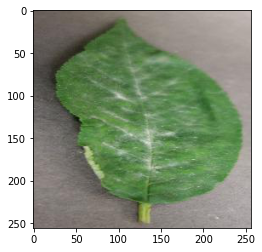

In [12]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [13]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [14]:
# freeze pretrained model weights
ptm.trainable = False

In [15]:
# map the data into feature vectors

# Keras image data generator returns classes one-hot encoded

K = len(folders) # number of classes
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [16]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [17]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [18]:
# create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
  rotation_range=90,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [19]:
batch_size = 256

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 46159 images belonging to 38 classes.
Found 8146 images belonging to 38 classes.


In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy',f1_m,precision_m, recall_m]
)

In [22]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=5,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Epoch 1/5
176/176 [==============================] - 936s 5s/step - loss: 4.4025 - accuracy: 0.8088 - f1_m: 0.8094 - precision_m: 0.8101 - recall_m: 0.8086 - val_loss: 1.9413 - val_accuracy: 0.8987 - val_f1_m: 0.8987 - val_precision_m: 0.8990 - val_recall_m: 0.8984
Epoch 2/5
176/176 [==============================] - 906s 5s/step - loss: 1.7223 - accuracy: 0.8987 - f1_m: 0.8989 - precision_m: 0.8992 - recall_m: 0.8985 - val_loss: 1.6732 - val_accuracy: 0.9170 - val_f1_m: 0.9169 - val_precision_m: 0.9169 - val_recall_m: 0.9168
Epoch 3/5
176/176 [==============================] - 894s 5s/step - loss: 1.6827 - accuracy: 0.9160 - f1_m: 0.9159 - precision_m: 0.9161 - recall_m: 0.9157 - val_loss: 1.4826 - val_accuracy: 0.9376 - val_f1_m: 0.9377 - val_precision_m: 0.9377 - val_recall_m: 0.9376
Epoch 4/5
176/176 [==============================] - 897s 5s/step - loss: 1.6364 - accuracy: 0.9253 - f1_m: 0.9255 - precision_m: 0.9257 - recall_m: 0.9254 - val_loss: 1.5149 - val_accuracy: 0.9399 - va

In [23]:


# evaluate the model
train_generator2 = gen_test.flow_from_directory(valid_path,target_size=IMAGE_SIZE,batch_size=batch_size,)
loss, accuracy, f1_score, precision, recall = model.evaluate(train_generator, steps=int(np.ceil(len(image_files) / batch_size)))

Found 8146 images belonging to 38 classes.
176/176 [==============================] - 898s 5s/step - loss: 1.6731 - accuracy: 0.9334 - f1_m: 0.9334 - precision_m: 0.9335 - recall_m: 0.9334


In [24]:
print(loss)
print(accuracy)
print(f1_score)
print(precision)
print(recall)

1.6731432676315308
0.9334161877632141
0.9334338903427124
0.9334962964057922
0.9333717823028564


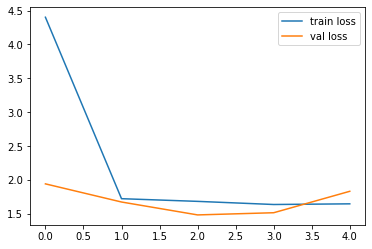

In [25]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

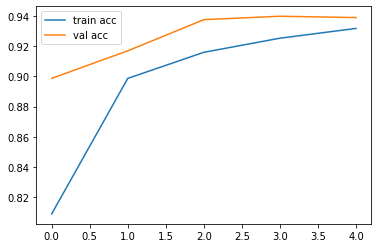

In [26]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

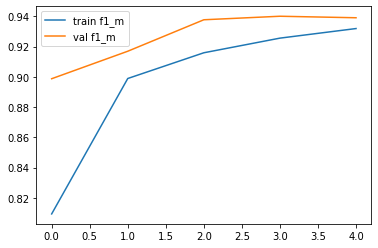

In [27]:
# accuracies
plt.plot(r.history['f1_m'], label='train f1_m')
plt.plot(r.history['val_f1_m'], label='val f1_m')
plt.legend()
plt.show()